In [10]:
import polars

max_length = 100_0
dataframe = polars.read_csv('../data/chessData.csv')
dataframe = dataframe.sample(shuffle=True, seed=42, n=max_length)
print(dataframe.head())

shape: (5, 2)
┌─────────────────────────────────┬────────────┐
│ FEN                             ┆ Evaluation │
│ ---                             ┆ ---        │
│ str                             ┆ str        │
╞═════════════════════════════════╪════════════╡
│ r1bq2k1/1p3pbp/p2p1np1/2pPr3/P… ┆ +57        │
│ R5k1/2nbqpp1/3b1n1p/2pPp3/2P1P… ┆ +82        │
│ rqr3k1/3npp2/3p2p1/1N1P3p/P1pR… ┆ +116       │
│ 8/5pp1/k5p1/1pK5/8/7P/5PP1/8 w… ┆ -317       │
│ 3r2k1/5p1p/1RN1p3/5nP1/1p6/2b1… ┆ +46        │
└─────────────────────────────────┴────────────┘


In [11]:
import numpy
from typing import Generator, Tuple
import itertools
import chess

ProductPiece = Tuple[chess.PieceType, chess.Color]


def generator_pieces() -> Generator[ProductPiece, None, None]:
    return itertools.product(chess.PIECE_TYPES, chess.COLORS)


def tokenize_fen(fen: str):
    board = chess.Board(fen=fen)
    
    # Pour chaque case, récupèrer la pièce, donner un indice entre 1-12 (13 si vide)
    # 1-6 : Pion, Cavalier, Fou, Tour, Reine, Roi (blanc)
    # 7-12 : Pion, Cavalier, Fou, Tour, Reine, Roi (noir)
    # 13 : Case vide
    board_array = numpy.array([])
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is None:
            board_array = numpy.append(board_array, 12)
        else:
            piece_type = piece.piece_type
            color = piece.color
            index = list(generator_pieces()).index((piece_type, color))
            board_array = numpy.append(board_array, index)
            
    board_array = board_array.astype(numpy.uint8)
    return tuple(board_array)

In [12]:
start_pos = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
result = tokenize_fen(start_pos)
print(len(result))
print(sum(result))

print(sum(result[:64]))  # white pawn
print(sum(result[64:128]))  # black pawn

print(sum(result[-128:-64]))  # white king
print(sum(result[-64:]))  # black king

print(result)

64
484
484
0
0
484
(6, 2, 4, 8, 10, 4, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 7, 3, 5, 9, 11, 5, 3, 7)


In [13]:
fen_column = "FEN"
score_column = "Evaluation"

expression = polars.col(fen_column).map_elements(tokenize_fen, return_dtype=polars.List(polars.UInt8))
preprocess_df = dataframe.with_columns(expression)

# Filtrer les lignes où la colonne ne contient pas '#-'
filtered_df = preprocess_df.filter(~polars.col(score_column).str.contains('#-'))
filtered_df = filtered_df.filter(~polars.col(score_column).str.contains('#+'))

# Convertir la colonne en entier
filtered_df = filtered_df.with_columns(polars.col(score_column).cast(polars.Int16))

min_value = filtered_df[score_column].min()
max_value = filtered_df[score_column].max()

print(f"Min value : '{min_value:.2f}  -  Max value : {max_value:.2f}")

# Le dataset contient '#+0' ou '#-0' dans score quand il y'a un mat, on remplace par le maximum de la couleur
expression = (
    polars
    .when(polars.col(score_column).str.contains('#+'))
    .then(polars.lit(f'{max_value}'))

    .when(polars.col(score_column).str.contains('#-'))
    .then(polars.lit(f'{min_value}'))

    .otherwise(polars.col(score_column))
    .alias(score_column))

preprocess_df = preprocess_df.with_columns(expression)

# Convertit le dtype string de 'score' en dtype float
expression = polars.col(score_column).cast(polars.Int16)
preprocess_df = preprocess_df.with_columns(expression)

# Ré-équilibre le dataset 
expression = polars.col(score_column).ne(0)
preprocess_df = preprocess_df.filter(expression)

# Si une valeur dépasse 2000 ou -2000, le remplace par 2000 ou -2000
# expression = polars.col(score_column).clip(-2000, 2000)
# preprocess_df = preprocess_df.with_columns(expression)

conditions = (
    polars.when(polars.col(score_column) >= 0).then(1)
    .when((polars.col(score_column) < 0)).then(0)
)
# Ajouter la colonne de classification au DataFrame
preprocess_df = preprocess_df.with_columns(conditions.alias("classification"))

# Renomme les colonnes en 'fen' et 'score'
preprocess_df = preprocess_df.rename({fen_column: 'fen', score_column: 'score'})

Min value : '-7918.00  -  Max value : 6233.00


In [14]:
print(preprocess_df.head())

shape: (5, 3)
┌────────────────┬───────┬────────────────┐
│ fen            ┆ score ┆ classification │
│ ---            ┆ ---   ┆ ---            │
│ list[u8]       ┆ i16   ┆ i32            │
╞════════════════╪═══════╪════════════════╡
│ [6, 12, … 12]  ┆ 57    ┆ 1              │
│ [12, 12, … 12] ┆ 82    ┆ 1              │
│ [6, 12, … 12]  ┆ 116   ┆ 1              │
│ [12, 12, … 12] ┆ -317  ┆ 0              │
│ [12, 12, … 12] ┆ 46    ┆ 1              │
└────────────────┴───────┴────────────────┘


In [15]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset


class ChessDataset(Dataset):
    def __init__(self, preprocess_df: polars.DataFrame):
        self.dataframe = preprocess_df

    def __getitem__(self, index: int):
        # Récupère la FEN et le score
        array = self.dataframe['fen'][index]
        _classification = self.dataframe['classification'][index]
        classification = [0 for i in range(2)]
        classification[_classification] = 1

        # Convertit le tableau numpy en tenseur PyTorch
        tensor_array = torch.tensor(array, dtype=torch.float32)
        tensor_classification = torch.tensor(classification, dtype=torch.float32)

        return tensor_array, tensor_classification

    def __len__(self):
        return len(self.dataframe)

    def hist_score(self, bins: int = 51):
        """
        Affiche un histogramme de la colonne 'score'.

        Notes:
            Incrémente bins de 1 si celui-ci est pair, cela permet d'afficher le nombre de
            zeros dans la colonne 'score'. En impair, nous n'avons que pour > 0 ou < 0.

        Args:
            bins (int): Nombre de "bacs" pour l'histogramme. Defaults to 51.

        Returns:
            None
        """
        # Si le nombre de bacs est pair, on l'incrémente de 1
        bins = bins + 1 if bins % 2 == 0 else bins

        # Créer un histogramme de la colonne 'score'
        plt.hist(self.dataframe['classification'], bins=bins)

        # Ajouter des étiquettes et un titre
        plt.xlabel('Valeur')
        plt.ylabel('Fréquence')
        plt.title('Distribution de la colonne "score"')

        # Afficher le graphique
        plt.show()

In [16]:
from torch.nn.functional import log_softmax
from torch import nn


import torch
import torch.nn as nn
import torch.optim as optim

class ChessModel(nn.Module):
    def __init__(self, vocab_size: int = 13):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, 2048)
        self.linear_1 = nn.Linear(2048, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _x = self.embeddings(x.long())
        _x = _x.sum(dim=1)
        _x = self.linear_1(_x)
        _x = self.linear_2(_x)
        _x = self.linear_3(_x)
        _x = log_softmax(_x, dim=1)
        return _x

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

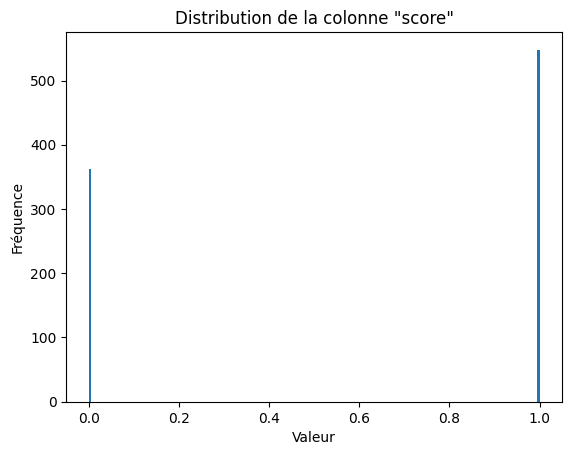

shape: (2, 2)
┌────────────────┬───────┐
│ classification ┆ count │
│ ---            ┆ ---   │
│ i32            ┆ u32   │
╞════════════════╪═══════╡
│ 0              ┆ 362   │
│ 1              ┆ 548   │
└────────────────┴───────┘


In [17]:
model = ChessModel()
dataset = ChessDataset(preprocess_df=preprocess_df)
dataset.hist_score(bins=201)
print(preprocess_df.get_column('classification').value_counts().sort("count"))

In [18]:
import logging
import statistics
from typing import Literal, Type

import torch
from torch import nn
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler, LinearLR
from torch.utils.data import DataLoader
from torchmetrics import Metric, MeanAbsoluteError
from tqdm import tqdm

from src import MODEL_PATH


def train_model(
        model: nn.Module,

        train_loader: DataLoader,
        tests_loader: DataLoader,
        validation_loader: DataLoader,

        num_epochs: int = 20,
        device: Literal['cuda', 'cuda'] = 'cuda',

        optimizer: Type[Optimizer] = torch.optim.Adam,
        metric: Metric = MeanAbsoluteError,
        criterion: _Loss = nn.MSELoss,

        lr: float = 1e-4,

        scheduler: Type[LRScheduler] = LinearLR,
        start_factor: float = 1.0,
        end_factor: float = 1e-6,
        total_iters: int = 10
):
    train_score, tests_score, validation_score = 0, 0, 0

    # Crée le modèle
    model = model.to(device)
    logging.info(f"Device: {model.device}")

    # noinspection PyArgumentList
    optimizer = optimizer(model.parameters(), lr=lr)

    # noinspection PyArgumentList
    scheduler = scheduler(
        optimizer=optimizer,
        start_factor=start_factor,
        end_factor=end_factor,
        total_iters=total_iters
    )

    metric_name = metric.__class__.__name__

    # Entraîne le modèle
    for epoch in range(num_epochs):
        pbar = tqdm(train_loader, total=len(train_loader), leave=False)

        list_loss = []
        for x, y in pbar:
            x = x.to(device=device)
            y = y.to(device=device)  # Met 'y' en batch_size de 1

            predictions = model(x).to(device=device)
            # print(x.shape, y.shape, predictions.shape)
            loss = criterion(predictions, y).to(device=device)
            # raise Exception()
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            pbar.set_description(f"Epochs: {epoch + 1}/{num_epochs}  -  Loss: {loss.item():.1e}")
            list_loss.append(loss.item())

        scheduler.step()
        # afficher sous forme 1e-3, 2e-3, 3e-3, etc.
        tqdm.write(f"Learning rate: {scheduler.get_last_lr()[0]:.1e}")
        train_score = check_accuracy(train_loader, model, metric)
        tests_score = check_accuracy(tests_loader, model, metric)

        avg_loss = statistics.mean(list_loss)
        tqdm.write(f"Epochs: {epoch + 1}/{num_epochs}  -  Loss: {avg_loss:.1e}  -  Train ({metric_name}): {train_score:.2f}  -  Tests ({metric_name}) : {tests_score:.2f}")

        # Sauvegarde le modèle
        path = MODEL_PATH / f"model_{epoch + 1}.pth"
        torch.save(model.state_dict(), path)

    # Affiche les derniers scores sur tout le dataset (tout les batchs)
    validation_score = check_accuracy(validation_loader, model, metric)

    logging.info(f"[Score global train] : {train_score:.2f}%")
    logging.info(f"[Score global tests] : {tests_score:.2f}%")
    logging.info(f"[Score global validation] : {validation_score:.2f}%")


def check_accuracy(
        loader: DataLoader,
        model: nn.Module,
        metrics: Metric,
):
    """
    Fonction pour calculer la précision du modèle
    """
    list_accuracy = []

    # Récupère le device du modèle
    device = model.device

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)  # Met 'y' en batch_size de 1

            predictions = model(x).to(device=device)

            accuracy = metrics(preds=predictions, target=y)
            list_accuracy.append(accuracy.item())

    global_accuracy = statistics.mean(list_accuracy)
    return global_accuracy


In [19]:
from torchmetrics.classification import BinaryAccuracy
import os

import torchmetrics
from typing import Literal
from src.dataset import split_dataset

# Autres paramètres
device: Literal['cuda', 'cuda'] = 'cuda'

# Paramètres du dataset
batch_size: int = 256
random_seed: int = 42
ratio_tests: float = 0.2
ratio_validation: float = 0.2

# Paramètres du modèle (apprentissage)
num_epochs: int = 100
lr: float = 1e-3

# Paramètres du scheduler_lr (apprentissage)
start_factor: float = 1.0
end_factor: float = 0.01
total_iters: int = 0

metric = BinaryAccuracy().to(device)
criterion = nn.CrossEntropyLoss()

list_loaders = split_dataset(
    dataset=dataset,
    batch_size=batch_size,
    shuffle_dataset=False,
    random_seed=random_seed,
    ratio_tests=ratio_tests,
    ratio_validation=ratio_validation
)

train_loader, tests_loader, validation_loader = list_loaders
import gc

gc.collect()

model = model.to(device)


train_model(
    device=device,

    model=model,
    train_loader=train_loader,
    tests_loader=tests_loader,
    validation_loader=validation_loader,

    num_epochs=num_epochs,
    lr=lr,

    start_factor=start_factor,
    end_factor=end_factor,
    total_iters=total_iters,

    metric=metric,
    criterion=criterion,
)

Learning rate: 1.0e-03
Epochs: 1/100  -  Loss: 2.8e+02  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 2/100  -  Loss: 2.0e+02  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 3/100  -  Loss: 1.3e+02  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 4/100  -  Loss: 5.5e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 5/100  -  Loss: 8.6e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 6/100  -  Loss: 1.3e+02  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03


Epochs: 7/100  -  Loss: 5.2e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 8/100  -  Loss: 5.5e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03


Epochs: 9/100  -  Loss: 6.3e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 10/100  -  Loss: 2.4e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 11/100  -  Loss: 1.4e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 12/100  -  Loss: 1.1e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 13/100  -  Loss: 1.2e+01  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 14/100  -  Loss: 6.6e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 15/100  -  Loss: 9.3e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 16/100  -  Loss: 3.4e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 17/100  -  Loss: 2.6e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 18/100  -  Loss: 3.2e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 19/100  -  Loss: 1.4e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 20/100  -  Loss: 1.7e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 21/100  -  Loss: 1.0e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


Learning rate: 1.0e-03
Epochs: 22/100  -  Loss: 1.0e+00  -  Train (BinaryAccuracy): 0.50  -  Tests (BinaryAccuracy) : 0.50


KeyboardInterrupt: 

In [20]:
from src import MODEL_PATH

path = MODEL_PATH / 'model_23.pth'
dict_model = torch.load(path, map_location='cuda')
model = ChessModel().to(device)
model.load_state_dict(dict_model)


def analys_model(fen: str):
    fen_array = tokenize_fen(fen)
    fen_tensor = torch.tensor(fen_array, dtype=torch.float32).view(1, -1).to(device)
    prediction = model(fen_tensor).argmax().item()

    print(f"Prédiction du modèle: {prediction:.2f}")
    print()


list_fen = [
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1",  # Position de base
    "r1bqkb1r/pppp1ppp/2n2n2/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 4 4",  # Mat berger, Mat en 1 pour blanc
    "4k3/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQ - 0 1",  # Noir n'ont qu'un roi
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/4K3 w kq - 0 1",  # Blanc n'ont qu'un roi
    "r3rbk1/p4ppp/8/2Nqp3/1p1P2b1/1P3N2/P2P1PPP/2RQR1K1 w - - 1 21"  # Position égale éloignée GMI (reputé légèrement favorable noir)
]

for fen in list_fen:
    analys_model(fen)

RuntimeError: Error(s) in loading state_dict for ChessModel:
	Unexpected key(s) in state_dict: "batch_norm_1.weight", "batch_norm_1.bias", "batch_norm_1.running_mean", "batch_norm_1.running_var", "batch_norm_1.num_batches_tracked", "batch_norm_2.weight", "batch_norm_2.bias", "batch_norm_2.running_mean", "batch_norm_2.running_var", "batch_norm_2.num_batches_tracked", "batch_norm_3.weight", "batch_norm_3.bias", "batch_norm_3.running_mean", "batch_norm_3.running_var", "batch_norm_3.num_batches_tracked", "linear_4.weight", "linear_4.bias". 
	size mismatch for linear_3.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for linear_3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2]).